In [1]:
from VariationalBayes.Models.LinearMixedModel.ConjugateModel import \
    get_base_prior_parameters, get_base_parameters, get_base_moment_parameters, set_moments, \
    LMMDataCache, CoordinateAscentUpdater, KLWrapper, MomentWrapper, ASISCoordinateAscent

from autograd import grad, hessian, jacobian, hessian_vector_product
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy as asp
import scipy as sp

import copy
from scipy import optimize

import time

In [29]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.
import os
import json

# Simulate data
N = 100     # observations per group
K = 4      # dimension of regressors
NG = 300      # number of groups

# Generate data
NObs = NG * N
true_beta = np.array(range(K))
true_beta = true_beta - np.mean(true_beta)
true_y_info = 1.0

true_mu = 1.0
true_mu_info = 40.0
true_u_sufficient = np.random.normal(true_mu, 1 / np.sqrt(true_mu_info), NG)
true_u_ancillary = true_u_sufficient - true_mu

x_mat = np.random.random(K * NObs).reshape(NObs, K) - 0.5
x_rot = np.full((K, K), 0.5)
for k in range(K):
    x_rot[k, k] = 1.0
x_mat = np.matmul(x_mat, x_rot)

y_g_vec = np.array([ g for g in range(NG) for n in range(N) ])
true_mean = np.matmul(x_mat, true_beta) + true_u_sufficient[y_g_vec]
y_vec = np.random.normal(true_mean, 1 / np.sqrt(true_y_info), NG * N)

print N * NG

30000


In [33]:
# Whether or not you are optimizing a sufficient or ancillary model.
sufficient = True

prior_par = get_base_prior_parameters(K)
lmm_par = get_base_parameters(K, NG, sufficient=sufficient)
moment_par = get_base_moment_parameters(K, NG, sufficient=sufficient)
data_cache = LMMDataCache(x_mat, y_vec, y_g_vec)

set_moments(lmm_par, moment_par)
init_moment_par = copy.deepcopy(moment_par)
init_par_vec = lmm_par.get_free()

moment_indices = copy.deepcopy(moment_par)
moment_indices.set_vector(np.array(range(moment_indices.vector_size())))

In [31]:
asis_updater = ASISCoordinateAscent(moment_par, data_cache, prior_par)

asis_time = time.time()
tol = 1e-9
delta = float('inf')
i = 0
max_iters = 5000
while delta > tol and i < max_iters:
    i += 1
    delta = asis_updater.update()
    if i % 5 == 0:
        print 'Iter %d, delta %f' % (i, delta)

if i < max_iters:
    asis_time = time.time() - asis_time
else:
    print 'ASIS did not converge.'
    asis_time = float('inf')

asis_moment_par_opt = copy.deepcopy(asis_updater.ca_updater_sufficient.moment_par)

print 'ASIS ascent time (in seconds): %f, iters: %d' % (asis_time, i)


Iter 5, delta 367.311316
Iter 10, delta 229.844714
Iter 15, delta 164.052042
Iter 20, delta 121.567859
Iter 25, delta 92.122744
Iter 30, delta 70.412184
Iter 35, delta 54.205689
Iter 40, delta 41.828484
Iter 45, delta 32.365961
Iter 50, delta 25.058926
Iter 55, delta 19.423833
Iter 60, delta 15.057037
Iter 65, delta 11.678027
Iter 70, delta 9.056808
Iter 75, delta 7.025707
Iter 80, delta 5.449724
Iter 85, delta 4.227808
Iter 90, delta 3.279685
Iter 95, delta 2.544364
Iter 100, delta 1.973831
Iter 105, delta 1.531291
Iter 110, delta 1.187941
Iter 115, delta 0.921599
Iter 120, delta 0.714961
Iter 125, delta 0.554662
Iter 130, delta 0.430299
Iter 135, delta 0.333822
Iter 140, delta 0.258975
Iter 145, delta 0.200911
Iter 150, delta 0.155864
Iter 155, delta 0.120918
Iter 160, delta 0.093807
Iter 165, delta 0.072774
Iter 170, delta 0.056458
Iter 175, delta 0.043799
Iter 180, delta 0.033979
Iter 185, delta 0.026361
Iter 190, delta 0.020450
Iter 195, delta 0.015865
Iter 200, delta 0.012308
Ite

In [34]:
# Perform coordinate ascent.
asis_init = False
if asis_init:
    if sufficient:
        ca_updater = CoordinateAscentUpdater(
            asis_updater.ca_updater_sufficient.moment_par, data_cache, prior_par, sufficient=sufficient)
    else:
        ca_updater = CoordinateAscentUpdater(
            asis_updater.ca_updater_ancillary.moment_par, data_cache, prior_par, sufficient=sufficient)
else:
    ca_updater = CoordinateAscentUpdater(init_moment_par, data_cache, prior_par, sufficient=sufficient)

ca_time = time.time()
tol = 1e-9
delta = float('inf')
i = 0
max_iters = 5000
while delta > tol and i < max_iters:
    i += 1
    delta = ca_updater.update()
    if i % 5 == 0:
        print 'Iter %d, delta %f' % (i, delta)

if i < max_iters:
    ca_time = time.time() - ca_time
else:
    print 'Coordinate ascent did not converge.'
    ca_time = float('inf')

ca_moment_par_opt = copy.deepcopy(ca_updater.moment_par)

print 'Coordinate ascent time (in seconds): %f, iters: %d' % (ca_time, i)

Iter 5, delta 3.485419
Iter 10, delta 0.044832
Iter 15, delta 0.000593
Iter 20, delta 0.000008
Iter 25, delta 0.000000
Iter 30, delta 0.000000
Coordinate ascent time (in seconds): 0.209244, iters: 31


In [36]:
kl_wrapper = KLWrapper(lmm_par, moment_par, prior_par, x_mat, y_vec, y_g_vec, sufficient=sufficient)
print kl_wrapper.kl(init_par_vec)

import timeit

time_num = 10

print 'Function time:'
print timeit.timeit(lambda: kl_wrapper.kl(init_par_vec), number=time_num) / time_num

print 'Grad time:'
print timeit.timeit(lambda: kl_wrapper.kl_grad(init_par_vec), number=time_num) / time_num

print 'Hessian vector product time:'
print timeit.timeit(lambda: kl_wrapper.kl_hvp(init_par_vec, init_par_vec + 1), number=time_num) / time_num

64294.0766118
Function time:
0.000592398643494
Grad time:
0.00787250995636
Hessian vector product time:
0.0149317026138


In [37]:
# Optimize.
vb_time = time.time()

# Note: to intialize the trust region with ASIS you'd have to get the natural parameters out of the moments.

print 'Running Newton Trust Region'
trust_init = copy.deepcopy(init_par_vec)
vb_opt = optimize.minimize(
    lambda par: kl_wrapper.kl(par, verbose=True),
    trust_init, method='trust-ncg', jac=kl_wrapper.kl_grad, hessp=kl_wrapper.kl_hvp,
    tol=1e-6, options={'maxiter': 500, 'disp': True, 'gtol': 1e-9 })

vb_time = time.time() - vb_time

lmm_par_opt = copy.deepcopy(lmm_par)
lmm_par_opt.set_free(vb_opt.x)

moment_par_opt = copy.deepcopy(moment_par)
set_moments(lmm_par_opt, moment_par_opt)

print 'trust region time (in seconds): %f' %  vb_time

Running Newton Trust Region
64294.0766118
50279.2347397
41070.5669878
35460.4802434
32710.9748235
30968.0031894
28804.0991913
28249.7279203
23961.3897602
23703.5277404
21663.2610237
20770.3451537
19715.6137036
19648.1022873
17244.050637
17019.4060643
16633.032048
16477.0094593
15208.9442366
15189.1108622
15177.5820606
14845.0974957
14843.7441247
14842.6213051
14776.0363218
14775.9715518
14775.888694
14770.302798
14770.3020762
14770.2975925
14770.2130286
14769.5243045
14769.5016342
14769.1709325
14769.167312
14768.9722054
14768.9717808
14768.8597119
14768.4133101
14768.3489546
14768.3484744
14768.3415143
14768.2409782
14768.2199251
14768.2154036
14768.1435279
14768.122594
14768.1216314
14768.115454
14768.0469694
14768.046956
14768.0406022
14768.0295317
14768.0209132
14768.0086448
14768.0086345
14768.0080233
14768.0080225
14768.0080224
14768.0080224
Optimization terminated successfully.
         Current function value: 14768.008022
         Iterations: 59
         Function evaluations: 6

In [38]:
# Make sure the coordinate ascent and trust region are close
moment_diff = np.sum(np.abs(ca_moment_par_opt.get_vector() - moment_par_opt.get_vector()))
moment_diff_asis = np.sum(np.abs(ca_moment_par_opt.get_vector() - asis_moment_par_opt.get_vector()))

print kl_wrapper.kl(vb_opt.x)

print 'total moment difference (ca vs asis): %f' % moment_diff_asis
print 'total moment difference (ca vs tr): %f' % moment_diff
print 'trust region seconds: %f' % vb_time
print 'coordinate ascent seconds: %f' % ca_time
print 'asis ascent seconds: %f' % asis_time

14768.0080224
total moment difference (ca vs asis): 393.089392
total moment difference (ca vs tr): 0.000000
trust region seconds: 14.359490
coordinate ascent seconds: 0.209244
asis ascent seconds: 11.543770


In [41]:
from VariationalBayes.Models.LinearMixedModel.ConjugateModel import get_elbo_model_term, get_entropy_from_moments
    
ca_entropy = get_entropy_from_moments(ca_moment_par_opt, lmm_par_guess=lmm_par_opt)
asis_entropy = get_entropy_from_moments(asis_moment_par_opt, lmm_par_guess=lmm_par_opt)

# Compare the optima found:
print '\nValues of the ELBO.  Larger is better.'
print ca_entropy + get_elbo_model_term(data_cache, ca_moment_par_opt, prior_par, sufficient=sufficient)
print -kl_wrapper.kl(vb_opt.x)
print asis_entropy + get_elbo_model_term(data_cache, asis_moment_par_opt, prior_par, sufficient=True)[0]


-3.376998764
-3.376998764
2.4442573716
2.44425737161
-4.38410083644
-3.376998764
2.04413173871
2.44425737161

Values of the ELBO.  Larger is better.
-14768.0080224
-14768.0080224
-23967.70361


--------------- beta:

[-1.5 -0.5  0.5  1.5]
[-1.52370288 -0.49837775  0.51506938  1.49231666]
--------------- mu:

1.00557433739
1.0
--------------- mu info:

34.2444897442
40.0
--------------- y info:

1.01206317884
1.0


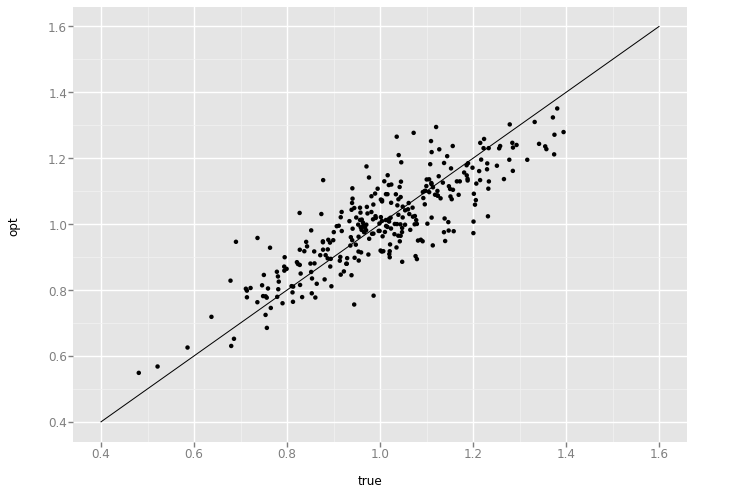

<ggplot: (8783134107553)>


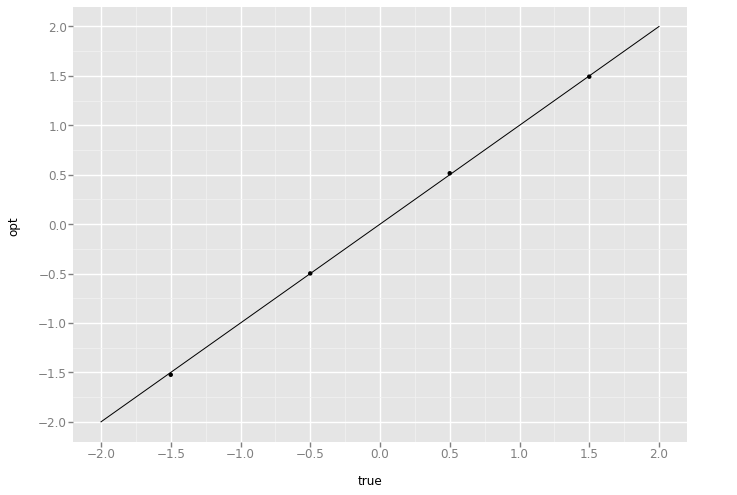

<ggplot: (8783141844441)>


In [42]:
# print(glmm_par_opt)
print '--------------- beta:\n'
print true_beta
print lmm_par_opt['beta'].e()

print '--------------- mu:\n'
print lmm_par_opt['mu'].e()[0]
print true_mu

print '--------------- mu info:\n'
print lmm_par_opt['mu_info'].e()[0]
print true_mu_info

print '--------------- y info:\n'
print lmm_par_opt['y_info'].e()[0]
print true_y_info


# Check the random effect estimates.  This requires simulated data.
from ggplot import *
import pandas as pd
%matplotlib inline

if sufficient:
    plot_df = pd.DataFrame({ 'opt': lmm_par_opt['u'].e(), 'true': true_u_sufficient })
else:
    plot_df = pd.DataFrame({ 'opt': lmm_par_opt['u'].e(), 'true': true_u_ancillary })
print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)

plot_df = pd.DataFrame({ 'opt': lmm_par_opt['beta'].e(), 'true': true_beta })
print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)


--------------- mu:

-1.01674194473
[-1.01674194]
--------------- mu info:

4.10321168445
[ 4.10321168]
--------------- y info:

0.998595206448
[ 0.99859521]


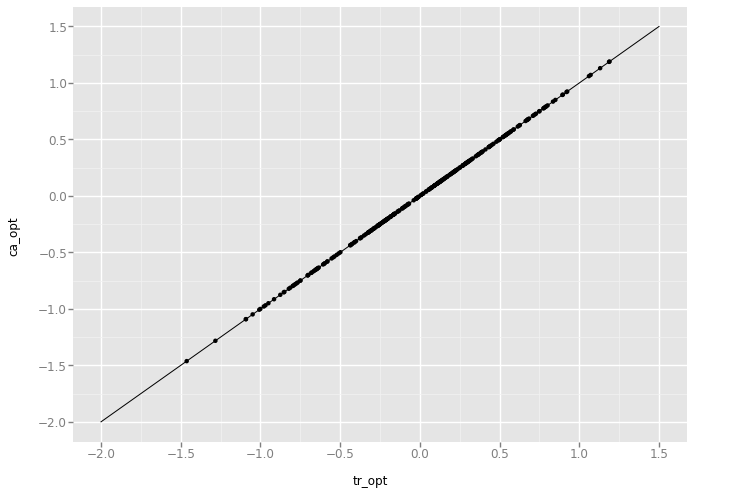

<ggplot: (8783134598645)>


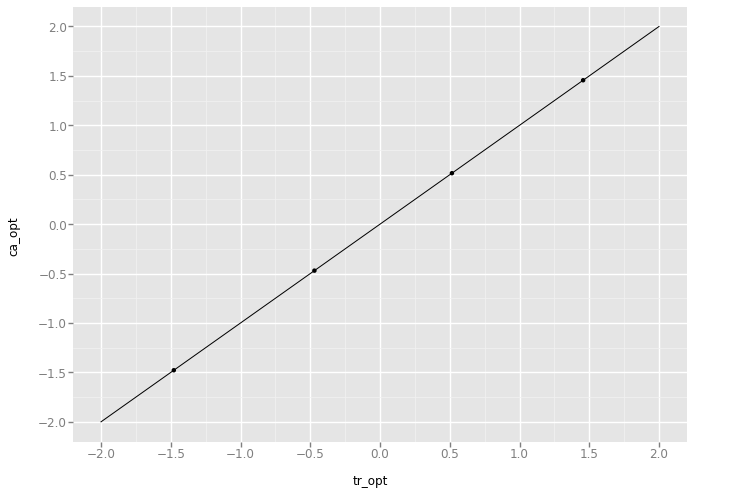

<ggplot: (8783134700845)>


In [12]:
# print(glmm_par_opt)

print '--------------- mu:\n'
print ca_moment_par_opt['e_mu'].get()
print moment_par_opt['e_mu'].get()

print '--------------- mu info:\n'
print ca_moment_par_opt['e_mu_info'].get()
print moment_par_opt['e_mu_info'].get()

print '--------------- y info:\n'
print ca_moment_par_opt['e_y_info'].get()
print moment_par_opt['e_y_info'].get()


plot_df = pd.DataFrame({ 'tr_opt': moment_par_opt['e_u'].get(), 'ca_opt': ca_moment_par_opt['e_u'].get() })
print ggplot(plot_df, aes(x='tr_opt', y='ca_opt')) + geom_point() + geom_abline(slope=1, intercept=0)

plot_df = pd.DataFrame({ 'tr_opt': moment_par_opt['e_beta'].get(), 'ca_opt': ca_moment_par_opt['e_beta'].get() })
print ggplot(plot_df, aes(x='tr_opt', y='ca_opt')) + geom_point() + geom_abline(slope=1, intercept=0)


--------------- mu:

1.00557433739
[-0.30473565]
--------------- mu info:

34.244489744
[ 22.95188425]
--------------- y info:

1.01206317884
[ 0.36968238]


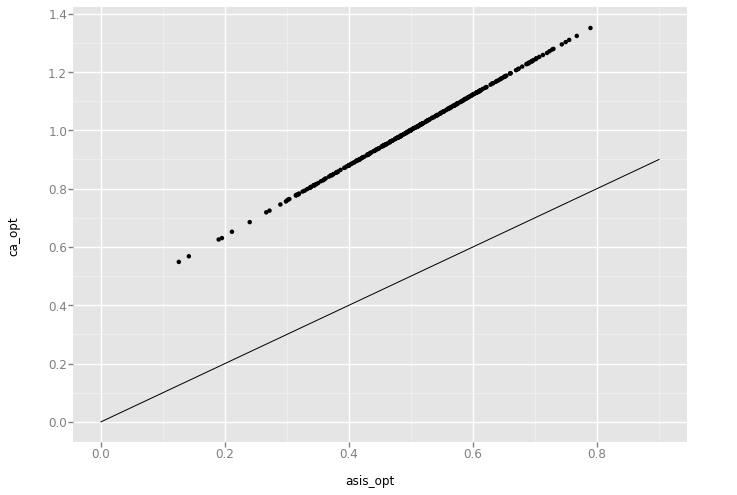

<ggplot: (8783134107553)>


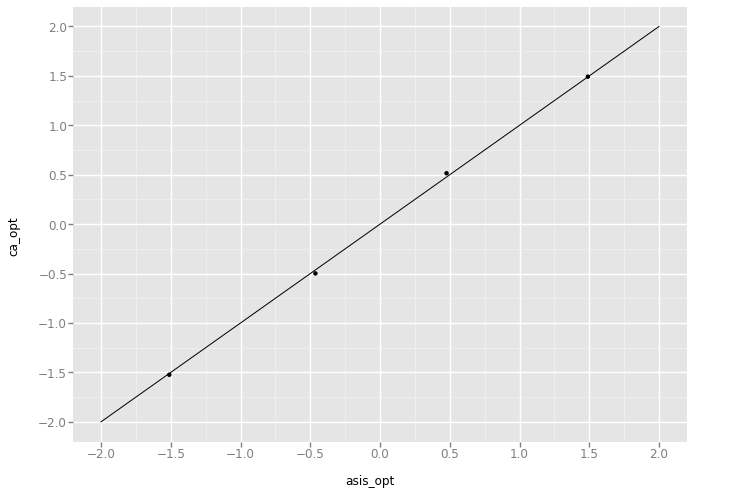

<ggplot: (8783134567065)>


In [43]:
# print(glmm_par_opt)

print '--------------- mu:\n'
print ca_moment_par_opt['e_mu'].get()
print asis_moment_par_opt['e_mu'].get()

print '--------------- mu info:\n'
print ca_moment_par_opt['e_mu_info'].get()
print asis_moment_par_opt['e_mu_info'].get()

print '--------------- y info:\n'
print ca_moment_par_opt['e_y_info'].get()
print asis_moment_par_opt['e_y_info'].get()


plot_df = pd.DataFrame({ 'asis_opt': asis_moment_par_opt['e_u'].get(), 'ca_opt': ca_moment_par_opt['e_u'].get() })
print ggplot(plot_df, aes(x='asis_opt', y='ca_opt')) + geom_point() + geom_abline(slope=1, intercept=0)

plot_df = pd.DataFrame({ 'asis_opt': asis_moment_par_opt['e_beta'].get(), 'ca_opt': ca_moment_par_opt['e_beta'].get() })
print ggplot(plot_df, aes(x='asis_opt', y='ca_opt')) + geom_point() + geom_abline(slope=1, intercept=0)


In [13]:
# Check differences if any

print moment_par_opt['e_mu_info']
print ca_moment_par_opt['e_mu_info']

print moment_par_opt['e_log_mu_info']
print ca_moment_par_opt['e_log_mu_info']

diffs = moment_par_opt.get_vector() - ca_moment_par_opt.get_vector()
print np.where(np.abs(diffs) > 1e-3)
print moment_indices

# plot_df = pd.DataFrame({ 'tr_opt': moment_par_opt['e_beta_outer'].get(), 'ca_opt': ca_moment_par_opt['e_beta_outer'].get() })
# print ggplot(plot_df, aes(x='tr_opt', y='ca_opt')) + geom_point() + geom_abline(slope=1, intercept=0)


e_mu_info: [ 4.10321168]
e_mu_info: 4.10321168445
e_log_mu_info: [ 1.40843742]
e_log_mu_info: 1.4084374161
(array([], dtype=int64),)
Moment Parameters:
	e_beta:
[0 1 2 3]
	e_beta_outer:
[[  4.   5.   7.  10.]
 [  5.   6.   8.  11.]
 [  7.   8.   9.  12.]
 [ 10.  11.  12.  13.]]
	e_mu: [14]
	e_mu2: [15]
	e_mu_info: [16]
	e_log_mu_info: [17]
	e_y_info: [18]
	e_log_y_info: [19]
	e_u:
[ 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171

In [14]:
# # Slow, but probably faster than using CG if you want the covariance of many parameters.
# hess_time = time.time()
# print 'Calculating KL Hessian...'
# kl_hess = kl_wrapper.kl_hess(vb_opt.x)
# hess_time =  time.time() - hess_time
# elbo_hess = -kl_hess
# print 'Done.'

# print 'Hessian time (seconds): %f' % hess_time

In [15]:
# hess_norm = np.sqrt(np.sum(kl_hess**2))
# diag_norm = np.sqrt(np.sum(np.diag(kl_hess)**2))

# # How diagonal is the Hessian?
# print 'Proportion of the frobenius norm off the diagonal:'
# print (hess_norm - diag_norm) / hess_norm